In [46]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def initial_spins(L):
    return np.random.choice([1, -1], size=(L,L))

def calculate_energy(spins, J, h, L):
    energy = 0
    for i in range(L):
        for j in range(L):
            energy -= h*spins[i, j]
            energy -= J*(spins[(i+1)%L, j] + spins[i, (j+1)%L])*spins[i,j]
    return energy

def metropolis_algorithim(spins, beta, J, h, L):
    #making a trial flip
    i, j = np.random.randint(0, L, size=2)
    site = spins[i, j]
    trial_flip = site * -1
    trial_flip_spins = spins.copy()
    trial_flip_spins[i, j] = trial_flip

    #calculating old energy
    old_energy = -h*spins[i, j] - J*(spins[(i+1)%L, j] + spins[i, (j+1)%L]+
                                     spins[(i - 1) % L, j] +  spins[i, (j-1)%L])*spins[i, j]
    #calculating new energy
    new_energy = -h*trial_flip_spins[i, j] - J*(trial_flip_spins[(i+1)%L, j] + trial_flip_spins[i, (j+1)%L]+
                                     trial_flip_spins[(i - 1) % L, j] +  trial_flip_spins[i, (j-1)%L])*trial_flip_spins[i, j]
    #computing delta E and deciding if we should accept the change
    #new_energy = calculate_energy(trial_flip_spins, J, h, L)
    #old_energy = calculate_energy(spins, J, h, L)

    delta_energy = new_energy - old_energy
    if delta_energy <= 0:
        spins[i, j] = trial_flip
       # print("For delta E = {}, the flip at site [{}, {}] was accepted".format(delta_energy, i, j))
    else:
        w = np.exp(-beta * delta_energy)
        r = random.random()
        if r <= w:
           # print("Random number {}, For delta E = {}".format(r, delta_energy))
            spins[i,j] = trial_flip

    return(spins)

def monte_carlo(beta, J, h, L, steps, spins):
    energies = [calculate_energy(spins, J, h, L)]
    mag_values = [magnetization(spins, L)]
    for step in range(steps):
        spins = metropolis_algorithim(spins, beta, J, h, L)
        if step % 100 == 0:
            energy = calculate_energy(spins, J, h, L)
            energies.append(energy)

            mag_value = magnetization(spins, L)
            mag_values.append(mag_value)

    return spins, energies, mag_values

def magnetization(spins, L):
    net_spin = 0
    for i in range(L):
        for j in range(L):
            net_spin += spins[i, j]
    return net_spin#/(L**2)

def specific_heat(energy_value, beta, L):
    average_energy = np.average(energy_value)
    average_energy_squared = np.average(np.square(energy_value))
    return (beta**2) *(average_energy_squared-(average_energy**2))/(L**2)

def heat_capacity(energy_value, beta, L):
    average_energy = np.average(energy_value)
    average_energy_squared = np.average(np.square(energy_value))
    return (beta**2) *(average_energy_squared-(average_energy**2))

def calculate_sus(magnetization_value, beta, L):
    # 1/T (<M^2> - <M>^2)
    M = np.average(magnetization_value)
    M_squared = np.average(np.square(magnetization_value))
    sus = beta*(M_squared - M**2)#/(L**2)
    return sus


def run_monte_carlo(beta, J, h, L, steps, spins):
    magnetization_values = []
    specific_heat_values = []
    susceptibility_values = []

    for beta_value in beta:
        copy_of_spins = spins.copy()
        final_spins, energy_accumulator, magnetization_acumulator = monte_carlo(beta_value, J, h, L, steps, copy_of_spins)

        magnetization_value = magnetization(final_spins, L)
        magnetization_values.append(magnetization_value)

        specific_heat_value = specific_heat(energy_accumulator, beta_value,L)
        specific_heat_values.append(specific_heat_value)

        susceptibility_value = calculate_sus(magnetization_acumulator, beta_value, L)
        susceptibility_values.append(susceptibility_value)

    return magnetization_values, specific_heat_values, susceptibility_values

def normalize(array):
    normalized_array = array.copy()
    max = np.max(array)
    min = np.min(array)
    for i in range(len(array)):
        normalized_array[i] = (array[i] - min)/(max-min)
    return normalized_array

def difference(array):
    differences = array.copy()[:-1]
    for i in range(len(array)-1):
        differences[i] = array[i+1] - array[i]
    return differences

def scatter_2D(data, ax, title):
    x = np.indices(data.shape)[0]
    y = np.indices(data.shape)[1]

    # 3D Plot
    p2d = ax.imshow(data, cmap="PiYG", vmin=-1, vmax=1)
    plt.colorbar(p2d, label="Spin")
    ax.set_title(title)
    return

def Visualization_of_MC(initial_spins, final_spins, energy, magnetization):
    cmap = "PiYG"
    fig = plt.figure(figsize=(12, 12))

    ax0 = fig.add_subplot(3, 2, 1,)
    scatter_2D(initial_spins, ax0, "Initial Lattice Configuration")

    ax1 = plt.subplot(3, 2, 2)
    scatter_2D(final_spins, ax1, "Final Lattice Configuration")

    ax2 = plt.subplot(3, 2, 3)
    scatter_2D(final_spins - initial_spins, ax2, "Residual Configuration")

    plt.subplot(3, 2, 4)
    plt.title("Energy vs. Monte Carlo Steps")
    plt.plot(range(0, len(energy) * 100, 100), energy, label="Energy", color='mediumvioletred')
    plt.xlabel("Monte Carlo Step")
    plt.ylabel("Energy")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.title("Normalized quantities")
    xs = np.linspace(0, steps, len(energy))
    plt.plot(xs, normalize(energy), label="Energy")
    plt.plot(xs, normalize(magnetization), label="Magnetization")
   # plt.plot(xs, normalize(specific_heat, label="Specific Heat")
   # plt.plot(xs, normalize(suseptibility, label="Susceptibility")
    # plt.plot(xs, normalize(quantities[4]), label="Correlation Length")  # TODO
    plt.xlabel("Monte Carlo Step")
    plt.ylabel("Normalized quantities")
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.title("Trace Plot")
    plt.plot(xs[:-1], difference(normalize(energy)), label="Energy")
    plt.plot(xs[:-1], difference(normalize(magnetization)), label="Magnetization")
 #  plt.plot(xs[:-1], difference(normalize(specific_heat)), label="Specific Heat")
  #  plt.plot(xs[:-1], difference(normalize(suseptibility)), label="Susceptibility")
    # plt.plot(xs[:-1], difference(quantities[4]), label="Correlation Length")  # TODO
    plt.xlabel("Monte Carlo Step")
    plt.ylabel("Difference in normalized quantity")
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

def Tc_from_sus(susceptibility_values, temperatures):
    i = susceptibility_values.index(max(susceptibility_values))
    Tc = temperatures[i]
    return Tc

def Tc_from_specific_heat(specific_heat_values, temperatures):
    i = specific_heat_values.index(max(specific_heat_values))
    Tc = temperatures[i]
    return Tc


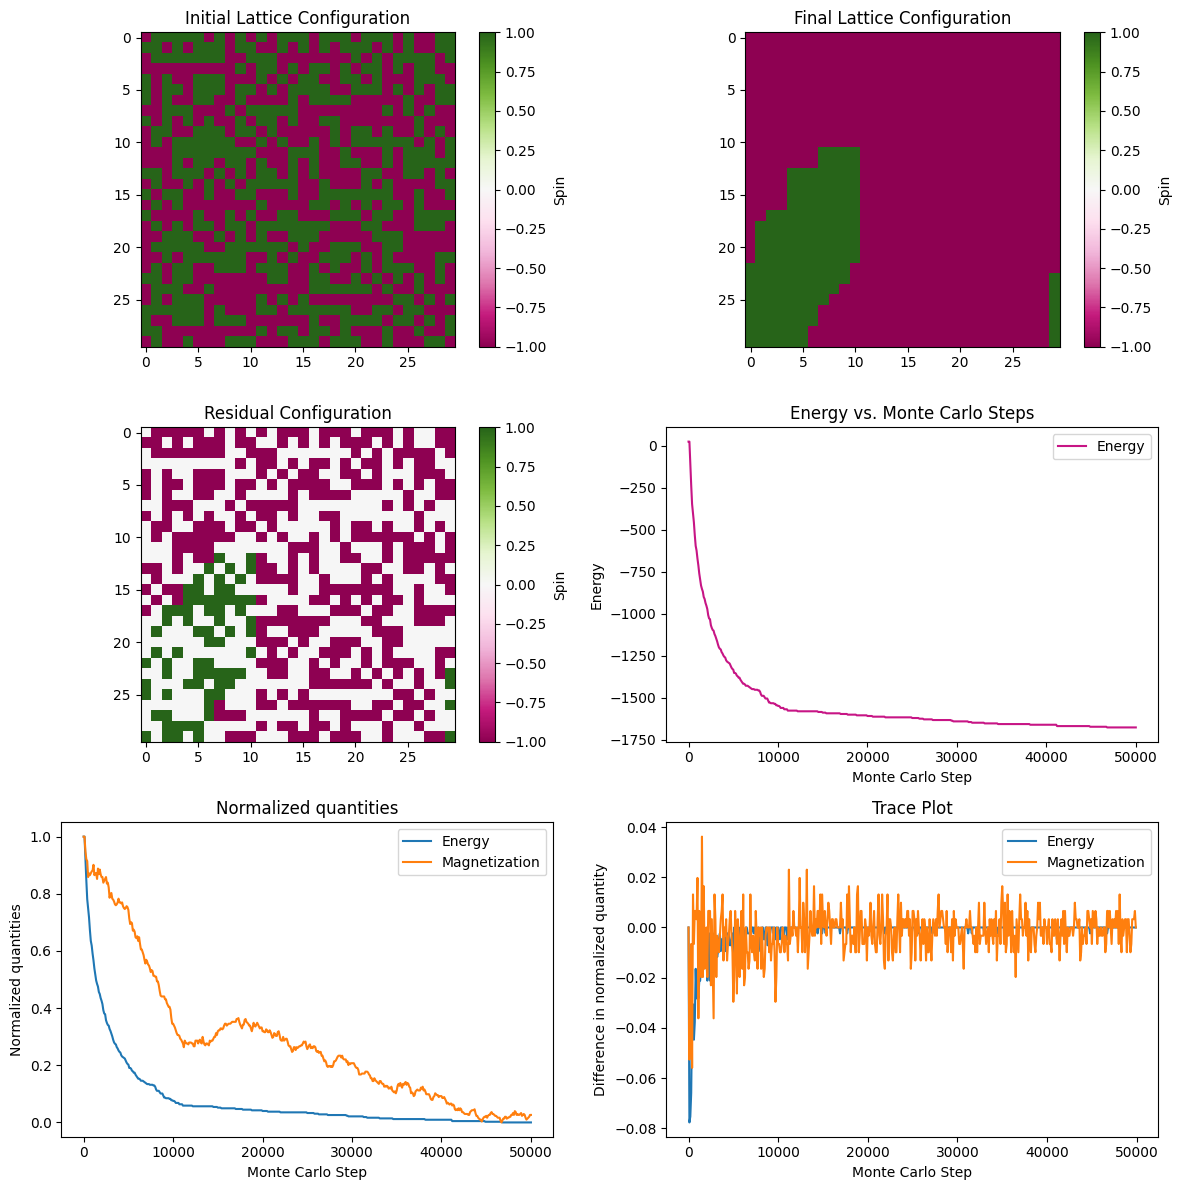

In [15]:
J = 1
h = 0
L = 30
beta = 100000
steps = 50000
spins_initial= initial_spins(L)
copy_of_spins_initial = spins_initial.copy()
final_spins, energy, mag_values = monte_carlo(beta, J, h, L, steps, copy_of_spins_initial)


Visualization_of_MC(spins_initial, final_spins, energy, mag_values)

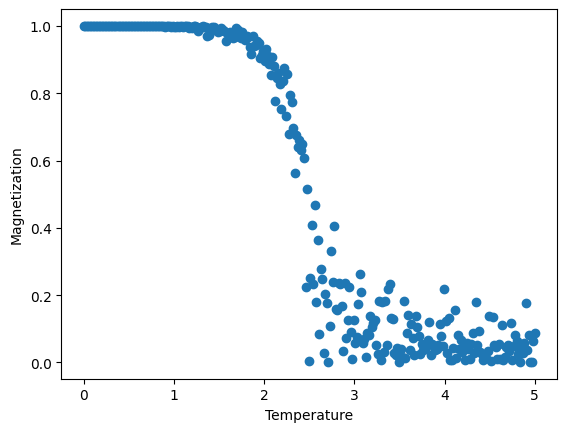

In [21]:
temp = np.linspace(0.0001, 5, 300)
beta = []
for temp_value in temp:
    beta.append(1/temp_value)
J = 1
h = 0
L = 25
steps = 30000


spins_initial = np.ones([L,L])

copy_of_spins_initial = spins_initial.copy()

magnetization_values, specific_heat_values, susceptibility_values = run_monte_carlo(beta, J, h, L, steps, copy_of_spins_initial)

plt.scatter(temp, np.abs(magnetization_values), label="Monte Carlo Steps")
plt.ylabel("Magnetization")
plt.xlabel("Temperature")
plt.show()



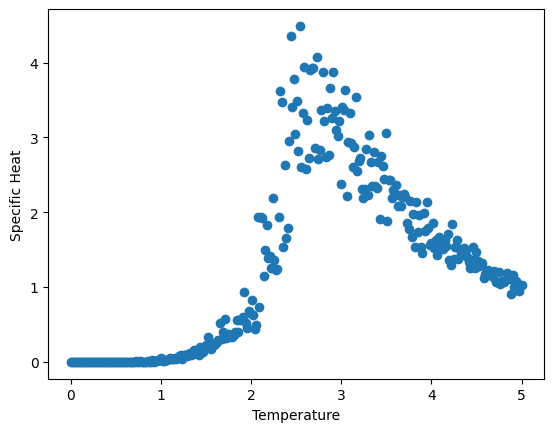

In [22]:
plt.scatter(temp, specific_heat_values, label="Monte Carlo Steps")
#plt.semilogy()
plt.ylabel("Specific Heat")
plt.xlabel("Temperature")
plt.show()

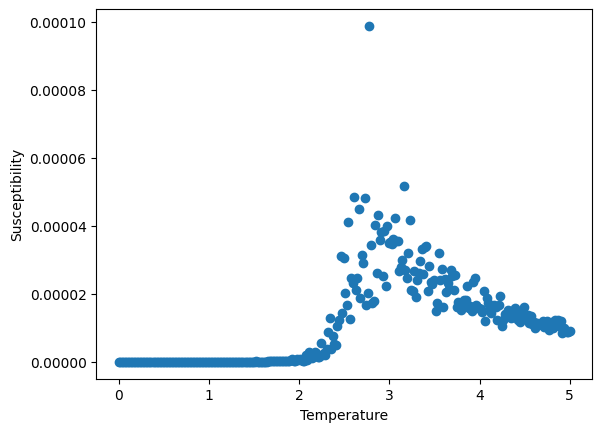

In [23]:
plt.scatter(temp, susceptibility_values, label="Monte Carlo Steps")
#plt.semilogy()
plt.ylabel("Susceptibility")
plt.xlabel("Temperature")
plt.show()


In [24]:
print("T_c is {} from susceptiblity".format(Tc_from_sus(susceptibility_values, temp)))
print("T_c is {} from specific heat".format(Tc_from_specific_heat(specific_heat_values, temp)))

T_c is 2.775964214046823 from susceptiblity
T_c is 2.5418551839464887 from specific heat


In [54]:
temp = np.linspace(0.0001, 5, 150)
beta = []
for temp_value in temp:
    beta.append(1/temp_value)
J = 1
h = 0
L_values = np.arange(2, 23, 10)
steps = 30000

Heat_Capacity_L = []
Sus_L=[]
mag_L=[]
for L in L_values:
    spins_initial = np.ones([L,L])
    copy_of_spins_initial = spins_initial.copy()
    magnetization_values, specific_heat_values, susceptibility_values = run_monte_carlo(beta, J, h, L, steps, copy_of_spins_initial)
    Tc_index = specific_heat_values.index(max(specific_heat_values))
    print(Tc_index)

    Heat_Capacity_L.append((specific_heat_values[Tc_index]))
    Sus_L.append(susceptibility_values[Tc_index]/L**2)
    mag_L.append(magnetization_values[Tc_index]/L**2)


78
67
84


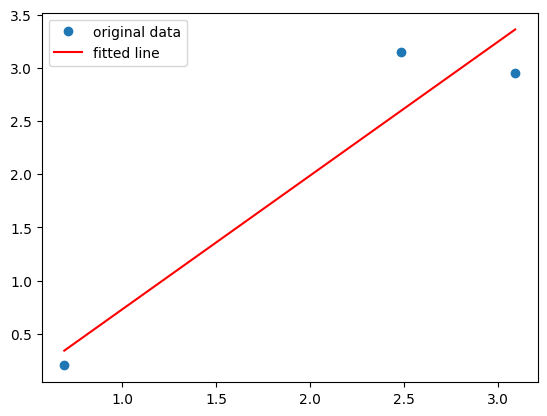

The graph is fit with the line y = 1.2602472116879935x + -0.5322964264915098


In [55]:
log_sus = np.log(Sus_L)
log_L = np.log(L_values)
res = stats.linregress(log_L, log_sus)
plt.plot(log_L, log_sus, 'o', label='original data')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='fitted line')
plt.legend()
plt.show()

print("The graph is fit with the line y = {}x + {}".format(res.slope, res.intercept))

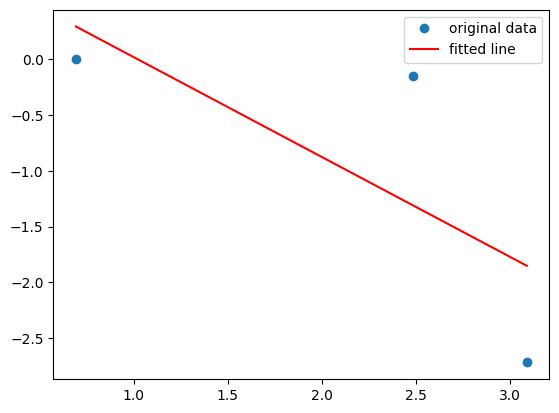

The graph is fit with the line y = -0.893819623158725x + 0.9125201799867415


In [56]:
log_M = np.log(np.abs(mag_L))
log_L = np.log(L_values)
res = stats.linregress(log_L, log_M)
plt.plot(log_L, log_M, 'o', label='original data')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='fitted line')
plt.legend()
plt.show()

print("The graph is fit with the line y = {}x + {}".format(res.slope, res.intercept))

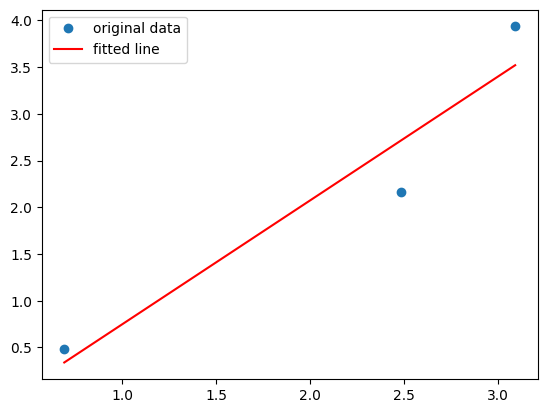

The graph is fit with the line y = 1.3267853646224599x + -0.5803565000012232


In [57]:

log_L = np.log(L_values)
res = stats.linregress(log_L, Heat_Capacity_L)
plt.plot(log_L, Heat_Capacity_L, 'o', label='original data')
plt.plot(log_L, res.intercept + res.slope*log_L, 'r', label='fitted line')
plt.legend()
plt.show()

print("The graph is fit with the line y = {}x + {}".format(res.slope, res.intercept))